In [2]:
import argparse
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

In [5]:
class MLP(nn.Module):
    def __init__(self, image_channels=1, hidden_size=128, hidden_layers=3):
        super().__init__()
        self.initial_conv = ConvBlock(image_channels, hidden_size, kernel_size=7, stride=2, padding=3)
        self.conv_blocks = nn.Sequential(*[ConvBlock(hidden_size, hidden_size) for _ in range(hidden_layers - 1)])
        self.upsample = nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1)  
        self.final_conv = nn.Conv2d(hidden_size, image_channels, kernel_size=3, stride=1, padding=1)

        # ajouter des linear ( MLP ) pour le label 
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.conv_blocks(x)
        x = self.upsample(x)  # Application de l'upsample
        x = self.final_conv(x)
        return x



In [6]:
def train_bis(model, dataloader, optimizer, device, config):
    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        
        for noise_factor in np.arange(0.4, 4, 0.2):
            
            noise = torch.randn_like(data) * noise_factor 
            
            noisy_data = data + noise
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [7]:
def train_bis_bis(model, dataloader, optimizer, device, config):
    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        noisy_data= data.to(device)
        for i in range(10):
            noise = torch.randn_like(data) * 0.5
            noise = noise.to(device)   
            
            noisy_data_pred = noisy_data
            
            noisy_data = noisy_data_pred + noise
            
            noisy_data = noisy_data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, noisy_data_pred)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [8]:
def train_param(model, dataloader, optimizer, device, config):

    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        
        for noise_factor in np.arange(0.1, 1, 0.1):
            # noise factor = lambda 
            
            noise = torch.randn_like(data) * noise_factor 
            noisy_data = (1 - noise_factor) * data + noise
            
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [9]:

def main(config, train=train_param, path='mnist_model_param.pth'):
    losses = []
    val_losses = []
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    #dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
    
    # train and validation split 80% - 20%
    
    train_set, val_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
    dataloader = DataLoader(train_set, batch_size=config.train_batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=config.train_batch_size, shuffle=False)

    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    for epoch in range(config.num_epochs):
        # put data into device
        loss = train(model, dataloader, optimizer, device,config) # train à choisir 
        losses.append(loss)
        print(f"Epoch: {epoch+1}, Loss: {loss}")
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                noise_factor = np.random.uniform(0.1, 1)
                data = torch.randn_like(data) * noise_factor + (1 - noise_factor) * data
                data = data.to(device) 
                output = model(data)
                val_loss += F.mse_loss(output, data).item()
        val_loss /= len(val_loader)
        print(f"Validation loss: {val_loss}")
        
        val_losses.append(val_loss)
        
        
    plt.plot(losses)
    plt.title('Loss training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(val_losses)
    plt.title('Loss validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Sauvegarder le modèle
    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(), f"models/"+path) # Nom à changer à chaque fois 


In [61]:
class Config:
    train_batch_size = 32
    num_epochs = 15
    learning_rate = 1e-3
    num_timesteps = 50
    beta_schedule = "linear"
    eval_batch_size = 1000
    image_size =28
    
    
config = Config()
main(config)

0it [00:00, ?it/s]

7it [00:02,  2.35it/s]


KeyboardInterrupt: 

MLP(
  (initial_conv): ConvBlock(
    (conv): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
  (upsample): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([5, 1, 28, 28])


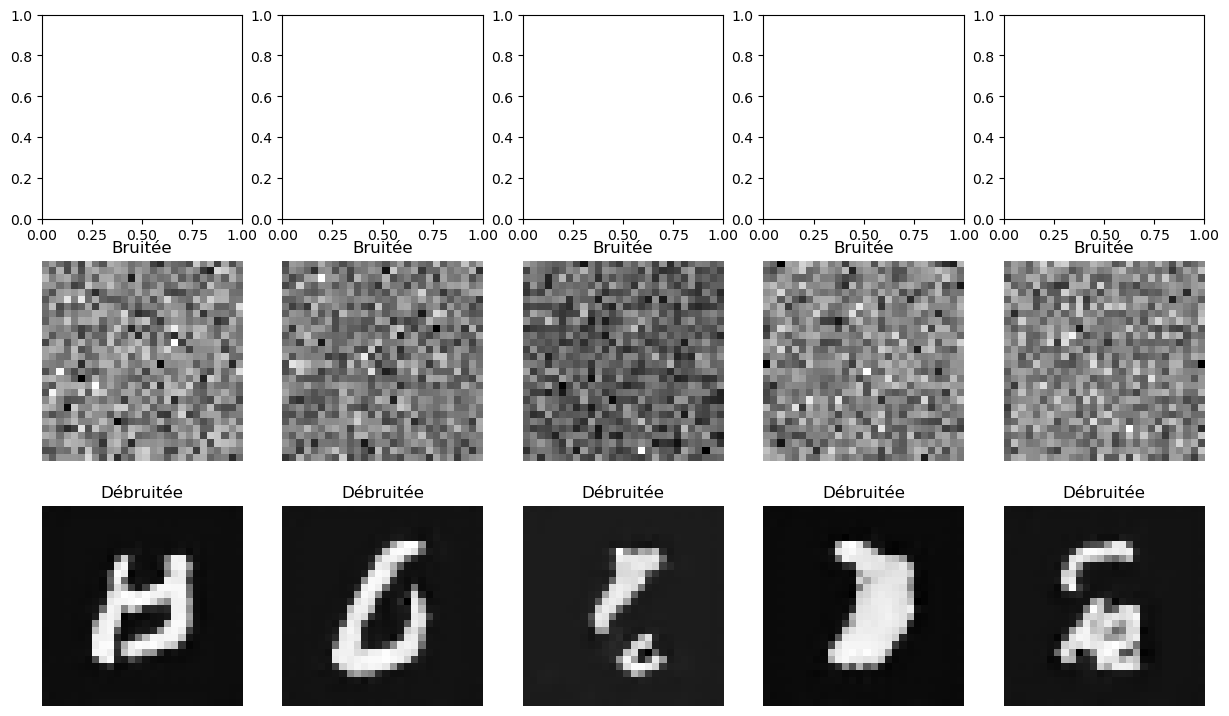

In [42]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)


model = MLP()
model.load_state_dict(torch.load('models/mnist_model_param.pth'))

# Afficher l'architecture du modèle
print(model)

# Prendre 5 images du dataset MNIST et les bruiter

images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images = model(noisy_images)
denoised_images = model(denoised_images)


print(denoised_images.shape)

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    """axs[0, i].imshow(images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Original')
    axs[0, i].axis('off')"""
    
    axs[1, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Bruitée')
    axs[1, i].axis('off')

    axs[2, i].imshow(denoised_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Débruitée')
    axs[2, i].axis('off')

plt.show()



MLP(
  (initial_conv): ConvBlock(
    (conv): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
  (upsample): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([5, 1, 28, 28])


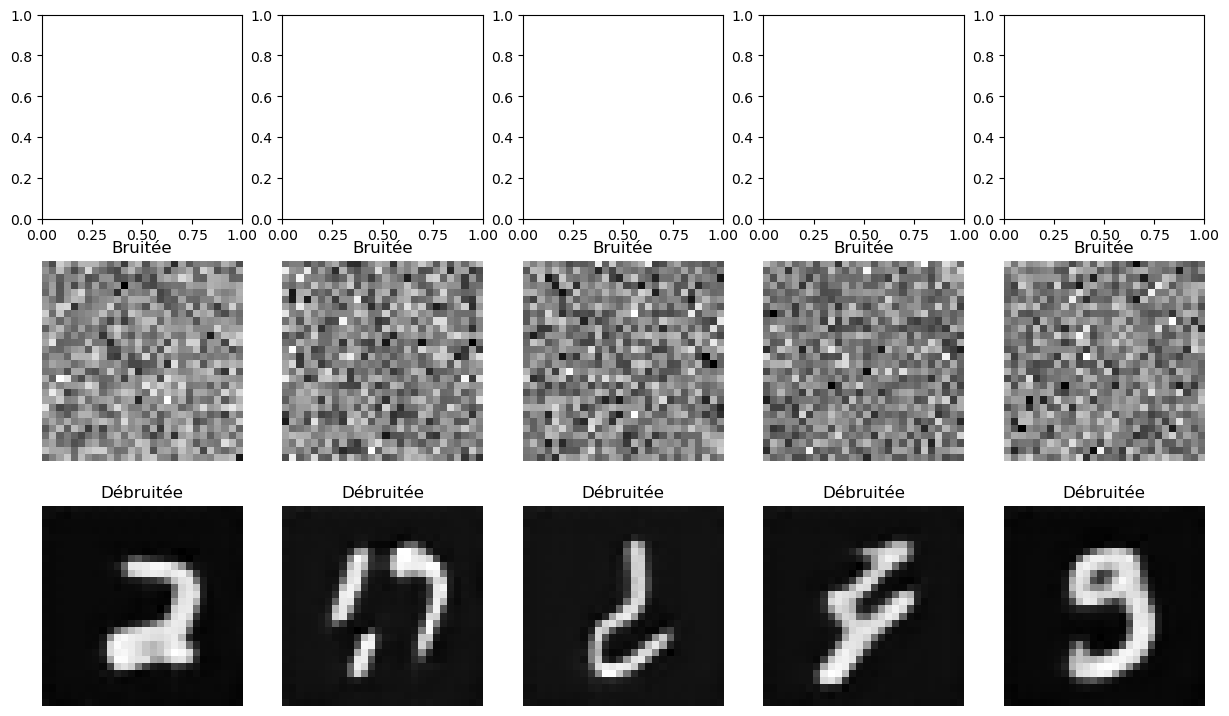

In [36]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)


model = MLP()
model.load_state_dict(torch.load('models/mnist_model_train_bis_0.2_15.pth'))

# Afficher l'architecture du modèle
print(model)

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images = model(noisy_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)

print(denoised_images.shape)

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    """axs[0, i].imshow(images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Original')
    axs[0, i].axis('off')"""
    
    axs[1, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Bruitée')
    axs[1, i].axis('off')

    axs[2, i].imshow(denoised_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Débruitée')
    axs[2, i].axis('off')

plt.show()



# Ablation study 

## Learning rate 

### train_bis

0it [00:00, ?it/s]

1500it [01:05, 22.98it/s]


Epoch: 1, Loss: 2.05298263797909
Validation loss: 0.9141379690170288


1500it [01:04, 23.23it/s]


Epoch: 2, Loss: 1.9704038590304553
Validation loss: 0.9351900045077006


1500it [01:04, 23.18it/s]


Epoch: 3, Loss: 1.9518338821524133
Validation loss: 0.8965308326880137


1500it [01:04, 23.17it/s]


Epoch: 4, Loss: 1.9418369821663946
Validation loss: 0.9648945293426514


1500it [01:04, 23.39it/s]


Epoch: 5, Loss: 1.9367008296406518
Validation loss: 0.9518674661318461


1500it [01:04, 23.36it/s]


Epoch: 6, Loss: 1.9314590457243224
Validation loss: 1.0062286863327026


1500it [01:04, 23.17it/s]


Epoch: 7, Loss: 1.928855257647112
Validation loss: 0.9500570547580719


1500it [01:04, 23.11it/s]


Epoch: 8, Loss: 1.9246061753978332
Validation loss: 0.9986794183254242


1500it [01:05, 23.06it/s]


Epoch: 9, Loss: 1.9231002146440248
Validation loss: 0.9559836312929789


1500it [01:04, 23.34it/s]


Epoch: 10, Loss: 1.9218622945155948
Validation loss: 0.9718707436720531


1500it [01:04, 23.32it/s]


Epoch: 11, Loss: 1.9204584150364001
Validation loss: 0.9676054037412007


1500it [01:04, 23.33it/s]


Epoch: 12, Loss: 1.9185418172335873
Validation loss: 0.9273181846141815


1500it [01:04, 23.31it/s]


Epoch: 13, Loss: 1.916990075685084
Validation loss: 0.9585505289236704


1500it [01:04, 23.14it/s]


Epoch: 14, Loss: 1.9165524688307196
Validation loss: 0.9748989160855611


1500it [01:05, 23.02it/s]


Epoch: 15, Loss: 1.9148595336998502
Validation loss: 0.9245455915927887


1500it [01:04, 23.17it/s]


Epoch: 16, Loss: 1.9138152665713182
Validation loss: 0.9454253746668497


1500it [01:05, 23.05it/s]


Epoch: 17, Loss: 1.9118970951512455
Validation loss: 0.9469991059303283


1500it [01:05, 22.84it/s]


Epoch: 18, Loss: 1.9128245778431494
Validation loss: 0.9507465309302012


1500it [01:04, 23.08it/s]


Epoch: 19, Loss: 1.910580839962388
Validation loss: 0.9602422365347545


1500it [01:07, 22.33it/s]


Epoch: 20, Loss: 1.9105552242963264
Validation loss: 0.9628888789017995


1500it [01:05, 22.78it/s]


Epoch: 21, Loss: 1.9099083499405534
Validation loss: 0.9303911579449972


1500it [01:12, 20.75it/s]


Epoch: 22, Loss: 1.9093447721793007
Validation loss: 0.977615687529246


1500it [01:07, 22.31it/s]


Epoch: 23, Loss: 1.9083731625247746
Validation loss: 0.9317839334805806


1500it [01:07, 22.12it/s]


Epoch: 24, Loss: 1.9086442934858303
Validation loss: 0.9305806285540262


1500it [01:16, 19.55it/s]


Epoch: 25, Loss: 1.907977933301901
Validation loss: 0.9609756793181101


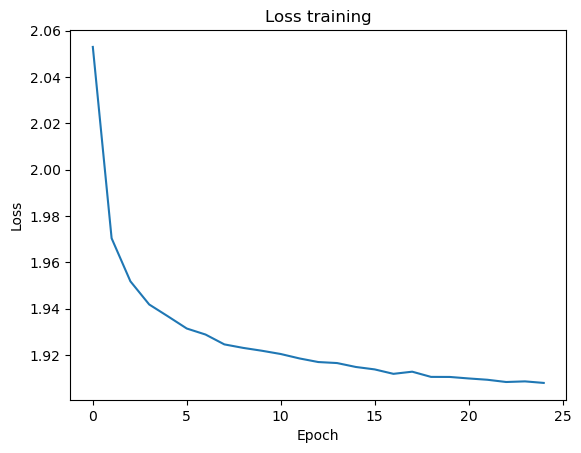

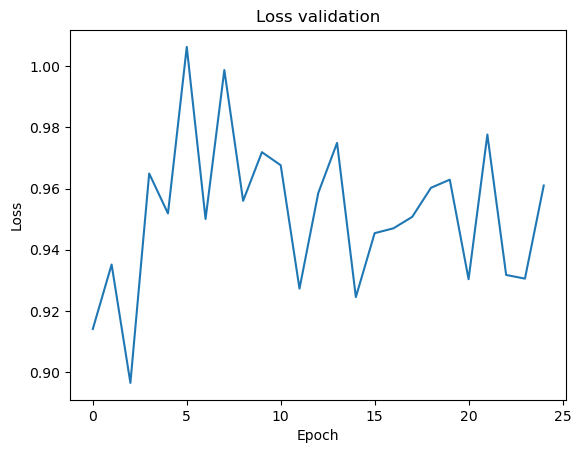

In [29]:

class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-3
    image_size =28
    
config = Config()
main(config, train=train_bis, path='mnist_model_train_bis_25_3.pth')

# 1 epoch : 1 min 

1500it [01:05, 22.91it/s]


Epoch: 1, Loss: 2.12438742864877
Validation loss: 0.8782755455176036


1500it [01:04, 23.16it/s]


Epoch: 2, Loss: 2.0136200794441006
Validation loss: 0.905853978395462


1500it [01:05, 22.90it/s]


Epoch: 3, Loss: 1.9859680083114655
Validation loss: 0.8862666824658711


1500it [01:05, 22.79it/s]


Epoch: 4, Loss: 1.9698580276723952
Validation loss: 0.9363140137990316


1500it [01:04, 23.09it/s]


Epoch: 5, Loss: 1.9591615139885494
Validation loss: 0.904930440266927


1500it [01:09, 21.69it/s]


Epoch: 6, Loss: 1.9515987325174113
Validation loss: 0.9091032269795736


1500it [01:15, 19.84it/s]


Epoch: 7, Loss: 1.9457045894109954
Validation loss: 0.9454658672014872


1500it [01:07, 22.08it/s]


Epoch: 8, Loss: 1.9403427581880242
Validation loss: 0.937144373814265


1500it [01:07, 22.09it/s]


Epoch: 9, Loss: 1.9367710143097987
Validation loss: 0.9107623591423034


1500it [01:06, 22.54it/s]


Epoch: 10, Loss: 1.9317863347735256
Validation loss: 0.9018975503444672


1500it [01:05, 22.82it/s]


Epoch: 11, Loss: 1.9298134258780628
Validation loss: 0.8984992729822795


1500it [01:08, 21.97it/s]


Epoch: 12, Loss: 1.9266451751415927
Validation loss: 0.8616566491127015


1500it [01:05, 23.00it/s]


Epoch: 13, Loss: 1.9259492321033032
Validation loss: 0.8769592097600301


1500it [01:05, 22.87it/s]


Epoch: 14, Loss: 1.9230923260170967
Validation loss: 0.8647040677865346


1500it [01:05, 22.83it/s]


Epoch: 15, Loss: 1.9219827656783164
Validation loss: 0.9038954960505168


1500it [01:05, 23.02it/s]


Epoch: 16, Loss: 1.9199138744877031
Validation loss: 0.9164867022832235


1500it [01:05, 22.85it/s]


Epoch: 17, Loss: 1.9177378903695692
Validation loss: 0.8805803973674774


1500it [01:05, 23.00it/s]


Epoch: 18, Loss: 1.9169720575915028
Validation loss: 0.8691958805720011


1500it [01:05, 22.84it/s]


Epoch: 19, Loss: 1.9156934969201684
Validation loss: 0.9299461213747661


1500it [01:05, 23.07it/s]


Epoch: 20, Loss: 1.9156159294471145
Validation loss: 0.8925847698052725


1500it [01:06, 22.67it/s]


Epoch: 21, Loss: 1.91277500801223
Validation loss: 0.9188799826304118


1500it [01:05, 22.86it/s]


Epoch: 22, Loss: 1.9120710287671536
Validation loss: 0.8823116381168365


1500it [01:07, 22.32it/s]


Epoch: 23, Loss: 1.9107660449401787
Validation loss: 0.9205058477719625


1500it [01:05, 22.97it/s]


Epoch: 24, Loss: 1.9103315490484238
Validation loss: 0.9197762320836385


1500it [01:05, 22.82it/s]


Epoch: 25, Loss: 1.910621488943075
Validation loss: 0.9123250184853872


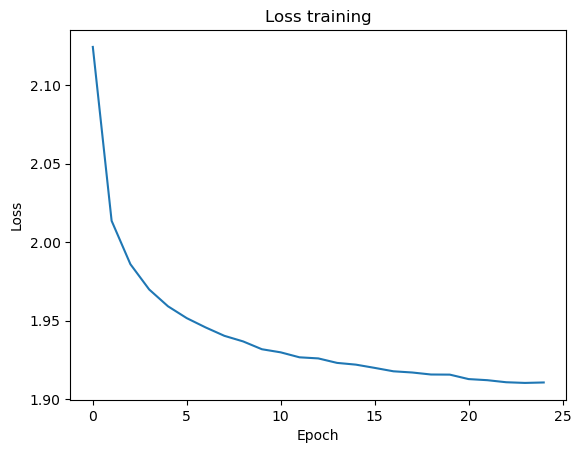

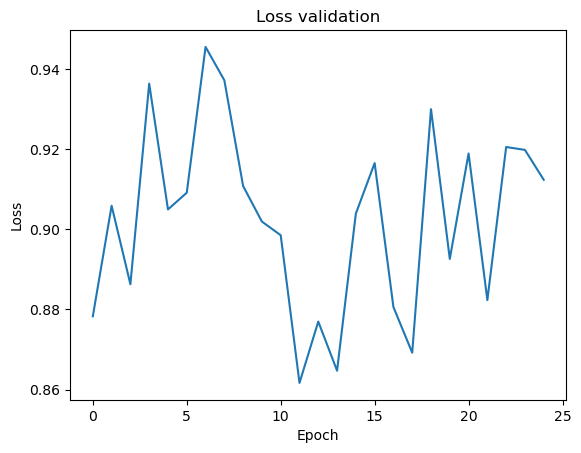

In [30]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-4
    image_size =28
    
config = Config()
main(config, train=train_bis, path='mnist_model_train_bis_25_4.pth')

0it [00:00, ?it/s]

1500it [01:05, 22.86it/s]


Epoch: 1, Loss: 2.346734720689555
Validation loss: 0.8926721688906352


1500it [01:05, 22.87it/s]


Epoch: 2, Loss: 2.1508482981386283
Validation loss: 0.8911797242164612


1500it [01:05, 22.92it/s]


Epoch: 3, Loss: 2.1086443649983653
Validation loss: 0.9559977947076161


1500it [01:05, 22.91it/s]


Epoch: 4, Loss: 2.0818478434787444
Validation loss: 0.968320584932963


1500it [01:05, 22.95it/s]


Epoch: 5, Loss: 2.061625911268716
Validation loss: 0.9584542249838511


1500it [01:06, 22.72it/s]


Epoch: 6, Loss: 2.047155607097472
Validation loss: 0.9561254507700602


1500it [01:07, 22.31it/s]


Epoch: 7, Loss: 2.0334141580052676
Validation loss: 1.00786399658521


1500it [01:06, 22.72it/s]


Epoch: 8, Loss: 2.0254186095303544
Validation loss: 0.890056133031845


1500it [01:05, 22.81it/s]


Epoch: 9, Loss: 2.016098003394281
Validation loss: 0.9165185895760855


1500it [01:05, 22.80it/s]


Epoch: 10, Loss: 2.0079143099505457
Validation loss: 0.9168570323785146


1500it [01:06, 22.50it/s]


Epoch: 11, Loss: 2.002713805148999
Validation loss: 0.9639511666297913


1500it [01:10, 21.36it/s]


Epoch: 12, Loss: 1.9965750507426758
Validation loss: 0.8460917139053344


1500it [01:09, 21.58it/s]


Epoch: 13, Loss: 1.992696669532607
Validation loss: 0.8865235377947489


1500it [01:09, 21.49it/s]


Epoch: 14, Loss: 1.987299131139492
Validation loss: 0.9014257339636484


1500it [01:09, 21.49it/s]


Epoch: 15, Loss: 1.9841964849289506
Validation loss: 0.9011996954282124


1500it [01:10, 21.37it/s]


Epoch: 16, Loss: 1.9806917286788424
Validation loss: 0.8935154883066813


1500it [01:10, 21.21it/s]


Epoch: 17, Loss: 1.9783909561851372
Validation loss: 0.8824075171152751


1500it [01:10, 21.37it/s]


Epoch: 18, Loss: 1.974952424120158
Validation loss: 0.8265531381766001


1500it [01:09, 21.58it/s]


Epoch: 19, Loss: 1.9720474264404426
Validation loss: 0.8597458243370056


1500it [01:09, 21.58it/s]


Epoch: 20, Loss: 1.969714167388777
Validation loss: 0.881848843574524


1500it [01:09, 21.54it/s]


Epoch: 21, Loss: 1.9660980291062344
Validation loss: 0.8369216459592184


1500it [01:09, 21.60it/s]


Epoch: 22, Loss: 1.9643477023020386
Validation loss: 0.8614769429365794


1500it [01:09, 21.60it/s]


Epoch: 23, Loss: 1.9629233456111204
Validation loss: 0.8208211645285288


1500it [01:09, 21.55it/s]


Epoch: 24, Loss: 1.9604475810459505
Validation loss: 0.8443639466762543


1500it [01:09, 21.66it/s]


Epoch: 25, Loss: 1.9585827457116296
Validation loss: 0.8240903429985046


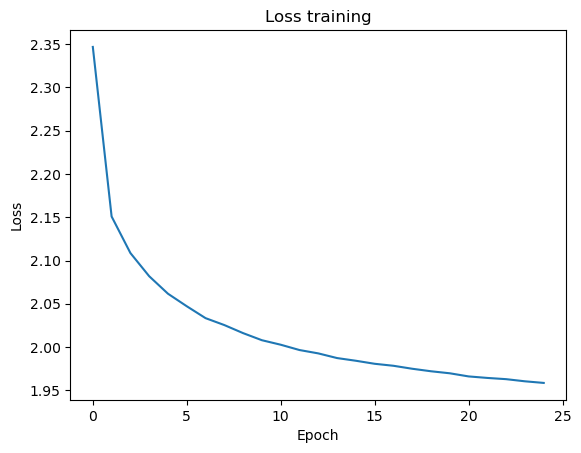

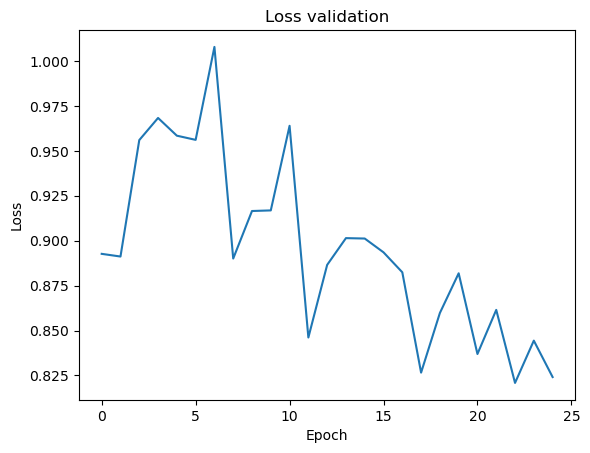

In [31]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-5
    image_size =28
    
config = Config()
main(config, train=train_bis, path='mnist_model_train_bis_25_5.pth')

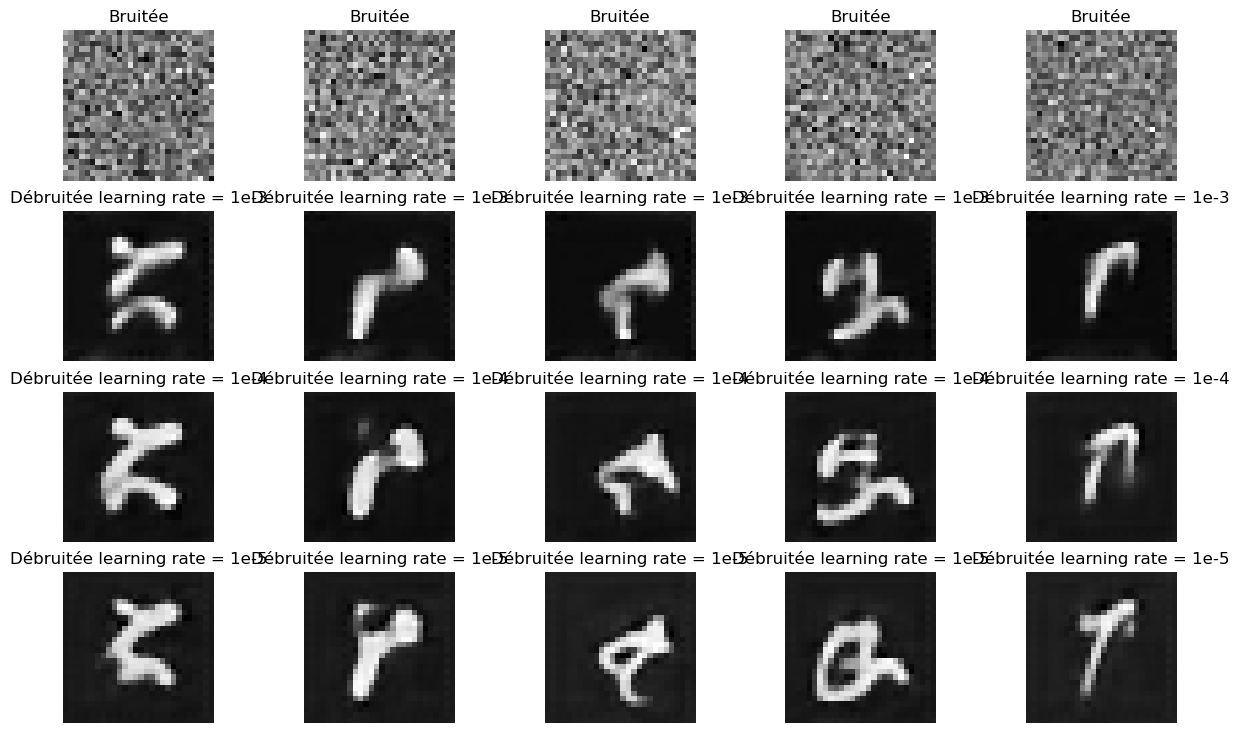

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_15_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_15_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_15_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)

denoised_images2 = model2(noisy_images)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)

denoised_images3 = model3(noisy_images)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)

fig, axs = plt.subplots(4, 5, figsize=(15, 9))
for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('Learning rate = 1e-5')
    axs[3, i].axis('off')

plt.show()


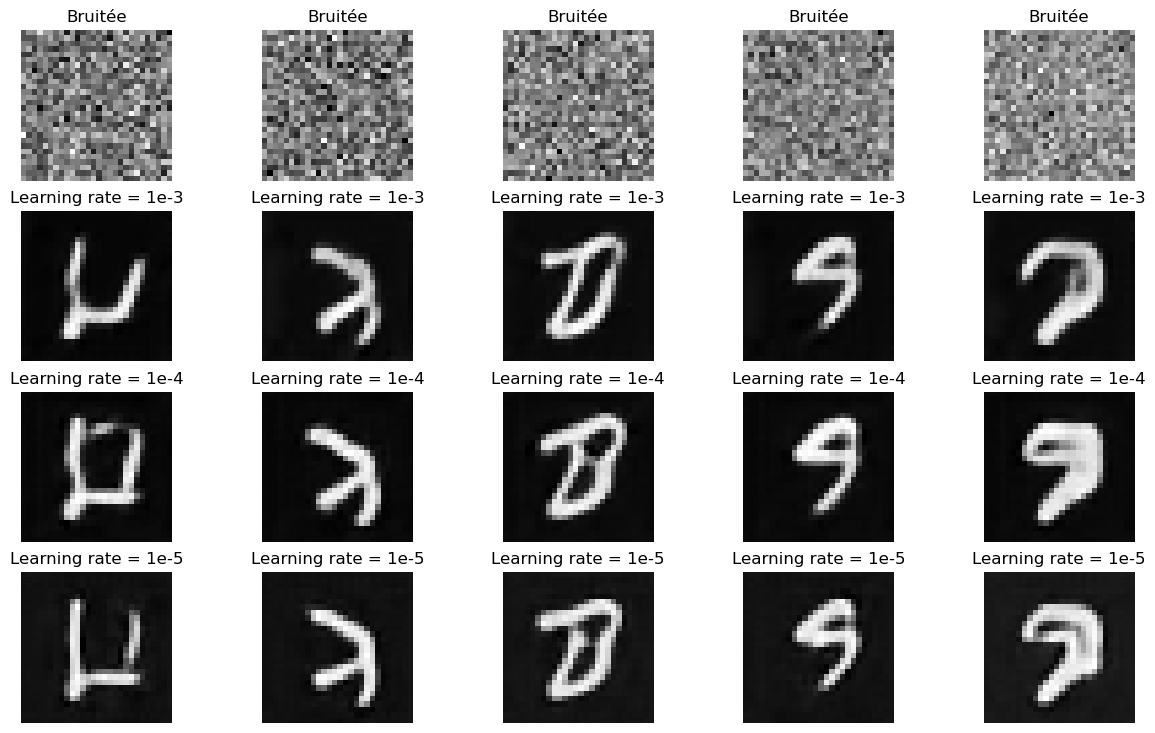

In [82]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_bis_25_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_bis_25_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_bis_25_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images2 = model2(noisy_images)
denoised_images3 = model3(noisy_images)

for i in range(3):
    denoised_images1 = model1(denoised_images1)
    denoised_images2 = model2(denoised_images2)
    denoised_images3 = model3(denoised_images3)

fig, axs = plt.subplots(4, 5, figsize=(15, 9))
for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('Learning rate = 1e-5')
    axs[3, i].axis('off')

plt.show()


### train_param

4it [00:00, 37.60it/s]

1500it [00:36, 41.02it/s]


Epoch: 1, Loss: 0.8328968544700183
Validation loss: 0.4760137126346429


1500it [00:37, 40.48it/s]


Epoch: 2, Loss: 0.7711713811261579
Validation loss: 0.5243779604534308


1500it [00:37, 40.10it/s]


Epoch: 3, Loss: 0.75965274576641
Validation loss: 0.5040325078070164


1500it [00:36, 41.61it/s]


Epoch: 4, Loss: 0.7542210035496392
Validation loss: 0.4970094263354937


1500it [00:36, 41.01it/s]


Epoch: 5, Loss: 0.7513868446373381
Validation loss: 0.5423476376036803


1500it [00:36, 41.03it/s]


Epoch: 6, Loss: 0.747505752506821
Validation loss: 0.5091326293051243


1500it [00:36, 40.75it/s]


Epoch: 7, Loss: 0.7461357073692294
Validation loss: 0.5042313655912876


1500it [00:37, 40.51it/s]


Epoch: 8, Loss: 0.7447654366035324
Validation loss: 0.4703889652391275


1500it [00:36, 40.63it/s]


Epoch: 9, Loss: 0.7427202129964716
Validation loss: 0.5107341577410698


1500it [00:36, 40.97it/s]


Epoch: 10, Loss: 0.7431141350429195
Validation loss: 0.5407251521845658


1500it [00:36, 41.15it/s]


Epoch: 11, Loss: 0.7407614566717917
Validation loss: 0.5119296117226283


1500it [00:36, 41.17it/s]


Epoch: 12, Loss: 0.7405475811604411
Validation loss: 0.5570987530549367


1500it [00:36, 41.35it/s]


Epoch: 13, Loss: 0.7397253716217044
Validation loss: 0.5310813684960206


1500it [00:37, 40.21it/s]


Epoch: 14, Loss: 0.738740524267933
Validation loss: 0.5486228902935981


1500it [00:36, 41.16it/s]


Epoch: 15, Loss: 0.7383512798828694
Validation loss: 0.5516657726168632


1500it [00:36, 41.52it/s]


Epoch: 16, Loss: 0.7385541394716129
Validation loss: 0.5674096361299356


1500it [00:37, 40.45it/s]


Epoch: 17, Loss: 0.7380805839107683
Validation loss: 0.4964559563199679


1500it [00:36, 41.36it/s]


Epoch: 18, Loss: 0.7385887721429268
Validation loss: 0.555432059019804


1500it [00:36, 40.97it/s]


Epoch: 19, Loss: 0.7368525904056926
Validation loss: 0.5588061139285564


1500it [00:36, 41.64it/s]


Epoch: 20, Loss: 0.7364893252688149
Validation loss: 0.5459946711262067


1500it [00:36, 41.32it/s]


Epoch: 21, Loss: 0.7364003115990199
Validation loss: 0.5501534253160159


1500it [00:36, 41.56it/s]


Epoch: 22, Loss: 0.7363456249129958
Validation loss: 0.527461211959521


1500it [00:37, 40.50it/s]


Epoch: 23, Loss: 0.7363517490397208
Validation loss: 0.5932434408267339


1500it [00:36, 41.15it/s]


Epoch: 24, Loss: 0.7364096877824825
Validation loss: 0.537935809592406


1500it [00:36, 41.28it/s]


Epoch: 25, Loss: 0.7360283608806009
Validation loss: 0.5325834274689356


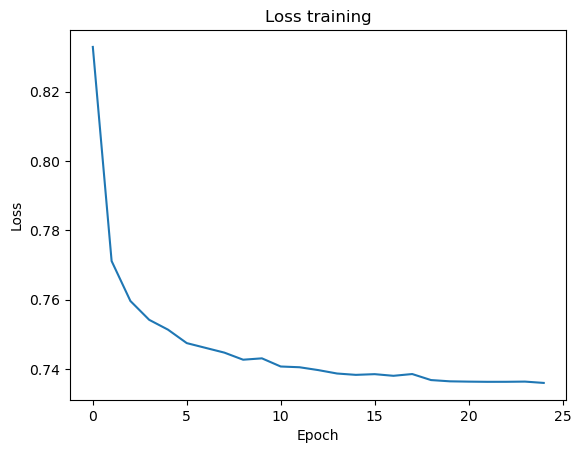

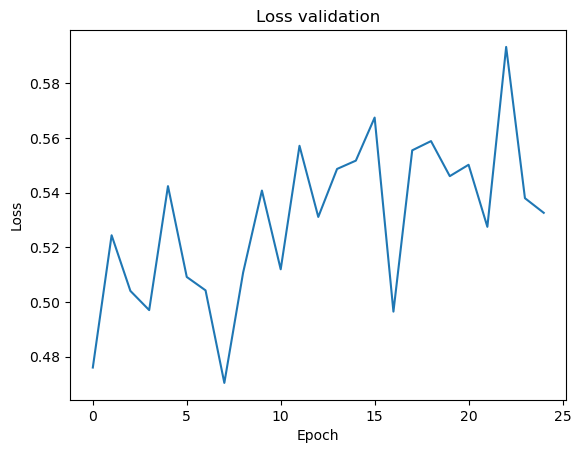

In [20]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-3
    image_size =28
    
config = Config()
main(config, train=train_param, path='mnist_model_train_param_0.1_25_3.pth')

0it [00:00, ?it/s]

1500it [00:36, 41.07it/s]


Epoch: 1, Loss: 0.8535225283624605
Validation loss: 0.4822063405017058


1500it [00:36, 40.92it/s]


Epoch: 2, Loss: 0.7879334742630211
Validation loss: 0.49264006557067236


1500it [00:36, 41.04it/s]


Epoch: 3, Loss: 0.7743930834070779
Validation loss: 0.477711583207051


1500it [00:36, 41.26it/s]


Epoch: 4, Loss: 0.7671317295706831
Validation loss: 0.46947589395940303


1500it [00:36, 41.05it/s]


Epoch: 5, Loss: 0.7609216516398204
Validation loss: 0.45431746514638266


1500it [00:35, 41.81it/s]


Epoch: 6, Loss: 0.7576575441999982
Validation loss: 0.4546438253919284


1500it [00:35, 41.78it/s]


Epoch: 7, Loss: 0.754885911249866
Validation loss: 0.46443456569314


1500it [00:35, 41.83it/s]


Epoch: 8, Loss: 0.7521968892163907
Validation loss: 0.48344234940906367


1500it [00:35, 41.93it/s]


Epoch: 9, Loss: 0.7500184054208608
Validation loss: 0.46510149561365444


1500it [00:35, 41.86it/s]


Epoch: 10, Loss: 0.7480677356602004
Validation loss: 0.49366836656133334


1500it [00:35, 41.88it/s]


Epoch: 11, Loss: 0.7463939106144631
Validation loss: 0.4614202000796795


1500it [00:35, 41.71it/s]


Epoch: 12, Loss: 0.7446486224249627
Validation loss: 0.4465093604723612


1500it [00:36, 41.58it/s]


Epoch: 13, Loss: 0.743766025557338
Validation loss: 0.4702671546638012


1500it [00:35, 41.70it/s]


Epoch: 14, Loss: 0.7434300249894149
Validation loss: 0.46557044834891953


1500it [00:36, 41.57it/s]


Epoch: 15, Loss: 0.7420454210370468
Validation loss: 0.5069225633144379


1500it [00:37, 40.37it/s]


Epoch: 16, Loss: 0.7411476998822764
Validation loss: 0.48675060496727623


1500it [00:37, 40.21it/s]


Epoch: 17, Loss: 0.7402639202397937
Validation loss: 0.47059678492943446


1500it [00:36, 40.86it/s]


Epoch: 18, Loss: 0.7393676482518203
Validation loss: 0.4999243834912777


1500it [00:36, 41.50it/s]


Epoch: 19, Loss: 0.7390774638056755
Validation loss: 0.49174324437975886


1500it [00:35, 41.74it/s]


Epoch: 20, Loss: 0.7387021903493441
Validation loss: 0.5079348457207282


1500it [00:36, 41.17it/s]


Epoch: 21, Loss: 0.7385763921188967
Validation loss: 0.5411735749542713


1500it [00:36, 41.32it/s]


Epoch: 22, Loss: 0.7376707368194281
Validation loss: 0.5087972353994846


1500it [00:35, 42.05it/s]


Epoch: 23, Loss: 0.7371856022836485
Validation loss: 0.48975497849782307


1500it [00:35, 42.21it/s]


Epoch: 24, Loss: 0.7369166052460204
Validation loss: 0.5101291055381298


1500it [00:35, 41.90it/s]


Epoch: 25, Loss: 0.7359388439652199
Validation loss: 0.49126585745811463


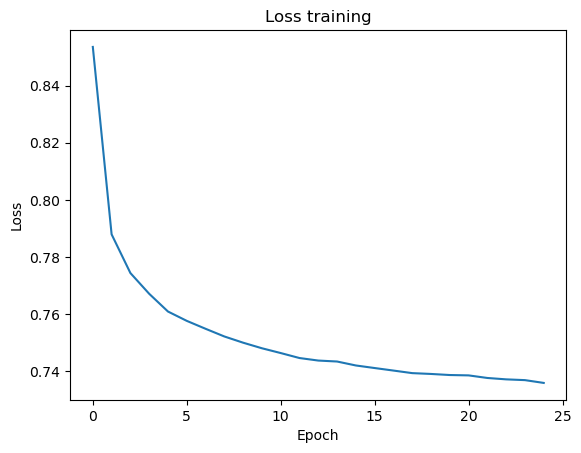

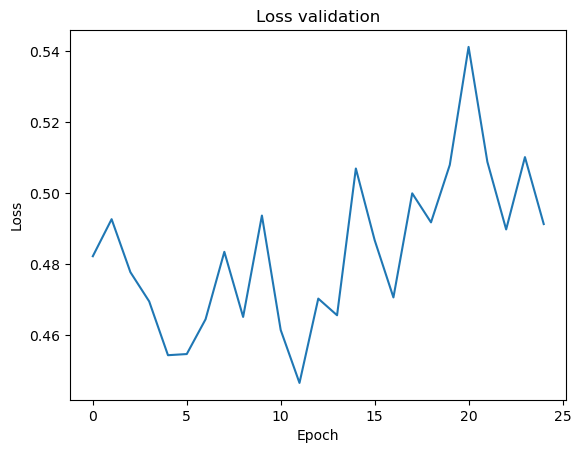

In [21]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-4
    image_size =28
    
config = Config()
main(config, train=train_param, path='mnist_model_train_param_0.1_25_4.pth')

0it [00:00, ?it/s]

1500it [00:35, 41.91it/s]


Epoch: 1, Loss: 0.9963085772022605
Validation loss: 0.5076013922890027


1500it [00:35, 42.09it/s]


Epoch: 2, Loss: 0.8595382606557881
Validation loss: 0.4869322853485743


1500it [00:36, 41.60it/s]


Epoch: 3, Loss: 0.834030140614137
Validation loss: 0.5010553970634938


1500it [00:35, 41.95it/s]


Epoch: 4, Loss: 0.8207991860977685
Validation loss: 0.4886374764740467


1500it [00:36, 41.50it/s]


Epoch: 5, Loss: 0.8109112392713627
Validation loss: 0.4770476497113705


1500it [00:37, 40.41it/s]


Epoch: 6, Loss: 0.8038604909881639
Validation loss: 0.47127721549073853


1500it [00:36, 40.86it/s]


Epoch: 7, Loss: 0.7976103453190687
Validation loss: 0.5047812053759893


1500it [00:36, 41.23it/s]


Epoch: 8, Loss: 0.7928134078957761
Validation loss: 0.4526015505194664


1500it [00:36, 41.02it/s]


Epoch: 9, Loss: 0.7886476557066975
Validation loss: 0.4483186620871226


1500it [00:36, 40.84it/s]


Epoch: 10, Loss: 0.7846417278624139
Validation loss: 0.4796593230267366


1500it [00:36, 41.44it/s]


Epoch: 11, Loss: 0.782119165895662
Validation loss: 0.48450013811389603


1500it [00:35, 41.97it/s]


Epoch: 12, Loss: 0.7792982824573603
Validation loss: 0.5005302953422069


1500it [00:35, 41.88it/s]


Epoch: 13, Loss: 0.7770530558863344
Validation loss: 0.5020948630174001


1500it [00:35, 42.42it/s]


Epoch: 14, Loss: 0.7752911010941801
Validation loss: 0.4659049621323744


1500it [00:35, 41.98it/s]


Epoch: 15, Loss: 0.7731807636829714
Validation loss: 0.48909420996904374


1500it [00:35, 41.86it/s]


Epoch: 16, Loss: 0.7715943898190745
Validation loss: 0.46268664198120435


1500it [00:35, 42.16it/s]


Epoch: 17, Loss: 0.7699133788890515
Validation loss: 0.4786299811005592


1500it [00:35, 42.18it/s]


Epoch: 18, Loss: 0.7685415695989505
Validation loss: 0.4741474443376064


1500it [00:36, 41.24it/s]


Epoch: 19, Loss: 0.7671744496123866
Validation loss: 0.4604989892144998


1500it [00:35, 42.08it/s]


Epoch: 20, Loss: 0.7659318219829971
Validation loss: 0.4590996431360642


1500it [00:35, 41.88it/s]


Epoch: 21, Loss: 0.7652371645993553
Validation loss: 0.4502405391136805


1500it [00:35, 41.71it/s]


Epoch: 22, Loss: 0.763434050172257
Validation loss: 0.4741324249903361


1500it [00:36, 41.16it/s]


Epoch: 23, Loss: 0.7627861997579846
Validation loss: 0.45235385874907175


1500it [00:36, 40.79it/s]


Epoch: 24, Loss: 0.7621938248431931
Validation loss: 0.44435054184993106


1500it [00:36, 41.03it/s]


Epoch: 25, Loss: 0.7611502122953534
Validation loss: 0.46430594589312874


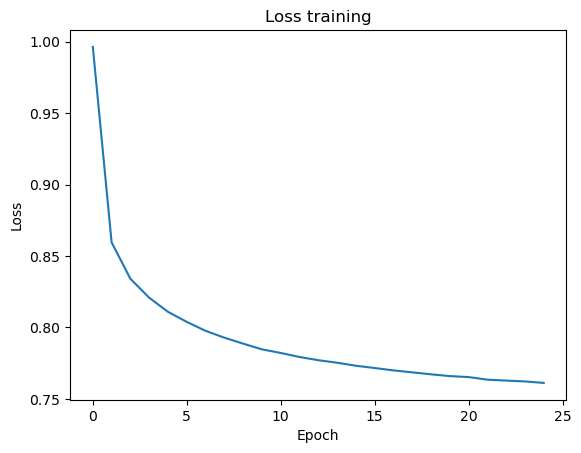

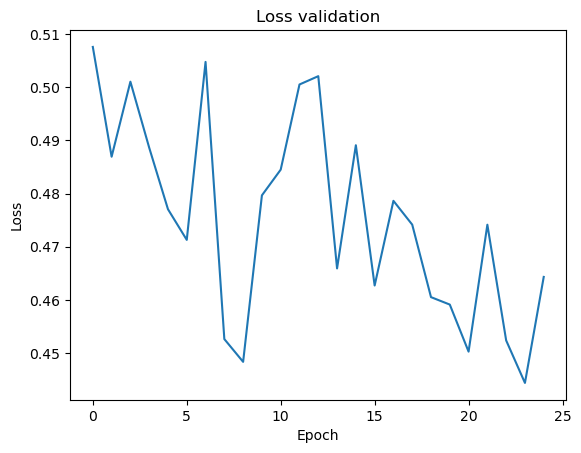

In [22]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-5
    image_size =28
    
config = Config()
main(config, train=train_param, path='mnist_model_train_param_0.1_25_5.pth')

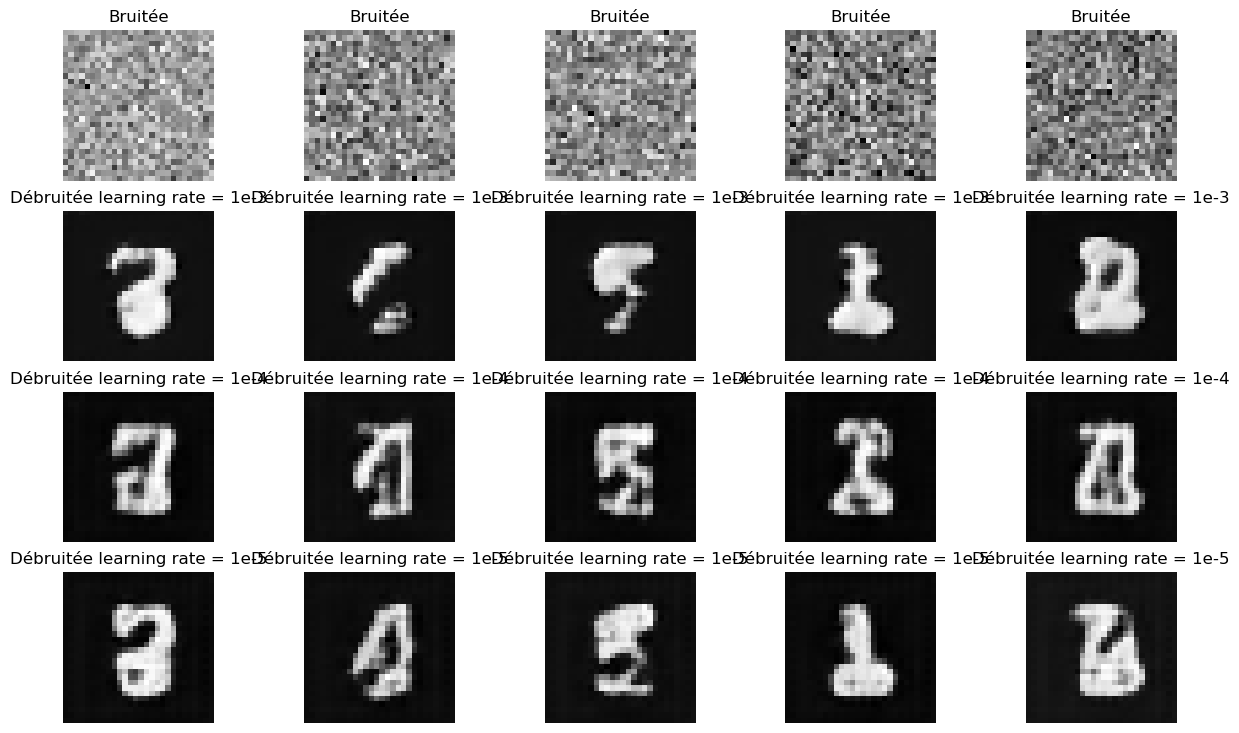

In [83]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

# we test the parametric model
model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_param_0.1_15_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_param_0.1_15_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_param_0.1_15_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.7*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)

denoised_images2 = model2(noisy_images)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2) 
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)


denoised_images3 = model3(noisy_images)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)


fig, axs = plt.subplots(4, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('learning rate = 1e-5')
    axs[3, i].axis('off')

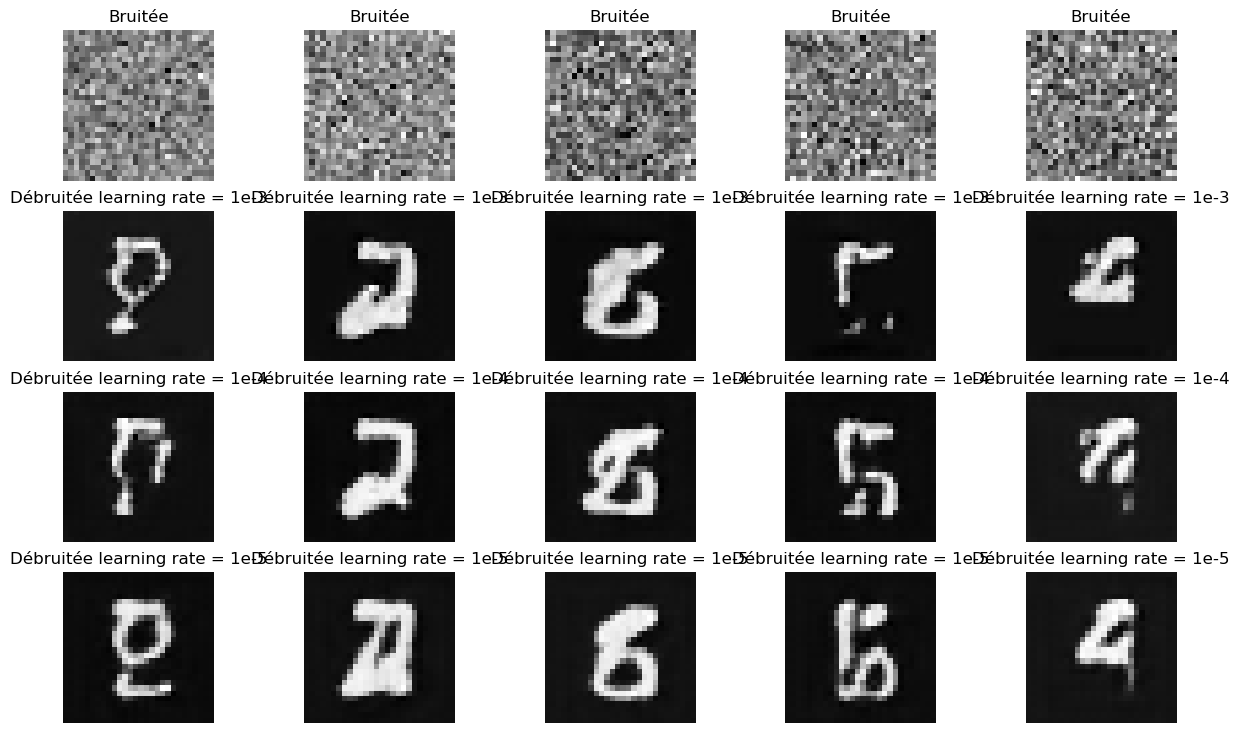

In [113]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

# we test the parametric model
model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_param_0.1_25_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_param_0.1_25_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_param_0.1_25_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.7*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images2 = model2(noisy_images)
denoised_images3 = model3(noisy_images)

for i in range(5):
    denoised_images1 = model1(denoised_images1)
    denoised_images2 = model2(denoised_images2)
    denoised_images3 = model3(denoised_images3)

fig, axs = plt.subplots(4, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('learning rate = 1e-5')
    axs[3, i].axis('off')

### train_bis_bis

0it [00:00, ?it/s]

1500it [00:40, 36.69it/s]


Epoch: 1, Loss: 1.9891845565512776
Validation loss: 0.05091594764590263


1500it [00:40, 37.41it/s]


Epoch: 2, Loss: 1.877654370645682
Validation loss: 0.04914159647996227


1500it [00:40, 37.49it/s]


Epoch: 3, Loss: 1.8504424539382258
Validation loss: 0.048564037217448154


1500it [00:39, 37.60it/s]


Epoch: 4, Loss: 1.83913117031008
Validation loss: 0.051138475829114516


1500it [00:39, 37.51it/s]


Epoch: 5, Loss: 1.8334951629135758
Validation loss: 0.05480100913718343


1500it [00:40, 36.92it/s]


Epoch: 6, Loss: 1.830583690142259
Validation loss: 0.059527309748033684


1500it [00:40, 36.85it/s]


Epoch: 7, Loss: 1.8307751232658824
Validation loss: 0.04870755760868391


1500it [00:40, 36.86it/s]


Epoch: 8, Loss: 1.832069505792732
Validation loss: 0.060051738880574704


1500it [00:40, 37.07it/s]


Epoch: 9, Loss: 1.8309764247989904
Validation loss: 0.05434424736599128


1500it [00:40, 36.99it/s]


Epoch: 10, Loss: 1.8296468752026558
Validation loss: 0.0554849605858326


1500it [00:40, 37.00it/s]


Epoch: 11, Loss: 1.8278364157968512
Validation loss: 0.054616711676120755


1500it [00:40, 37.43it/s]


Epoch: 12, Loss: 1.8262611453297237
Validation loss: 0.06607208298146725


1500it [00:40, 37.44it/s]


Epoch: 13, Loss: 1.826689507789289
Validation loss: 0.06423255713284015


1500it [00:40, 37.45it/s]


Epoch: 14, Loss: 1.8252484994238862
Validation loss: 0.047503307327628135


1500it [00:40, 37.44it/s]


Epoch: 15, Loss: 1.8242378335936615
Validation loss: 0.056765337377786634


1500it [00:39, 37.53it/s]


Epoch: 16, Loss: 1.8244331721620013
Validation loss: 0.05307989311094086


1500it [00:39, 37.55it/s]


Epoch: 17, Loss: 1.823990464831392
Validation loss: 0.05554645672440529


1500it [00:39, 37.56it/s]


Epoch: 18, Loss: 1.8235144084300845
Validation loss: 0.05400838140646617


1500it [00:39, 37.52it/s]


Epoch: 19, Loss: 1.822145200011631
Validation loss: 0.061399370282888416


1500it [00:40, 37.48it/s]


Epoch: 20, Loss: 1.8213628199553737
Validation loss: 0.05794212965418895


1500it [00:39, 37.50it/s]


Epoch: 21, Loss: 1.8214240297886233
Validation loss: 0.04964763676002622


1500it [00:39, 37.50it/s]


Epoch: 22, Loss: 1.8212816172676782
Validation loss: 0.05732101351767779


1500it [00:40, 37.48it/s]


Epoch: 23, Loss: 1.8205436898904541
Validation loss: 0.0597039086210231


1500it [00:40, 36.64it/s]


Epoch: 24, Loss: 1.820717691651235
Validation loss: 0.05247870109478633


1500it [00:40, 37.16it/s]


Epoch: 25, Loss: 1.8200139644710969
Validation loss: 0.059096266871939106


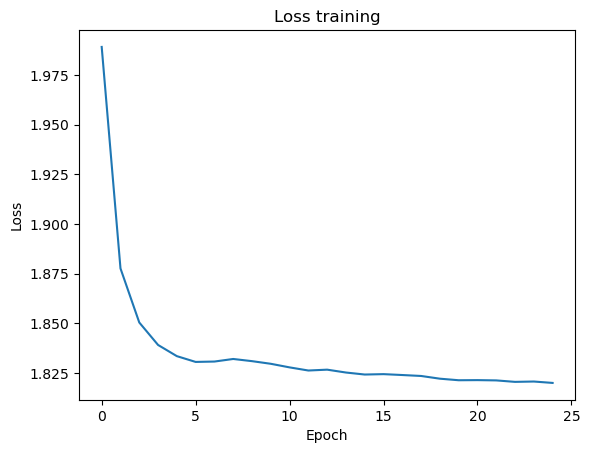

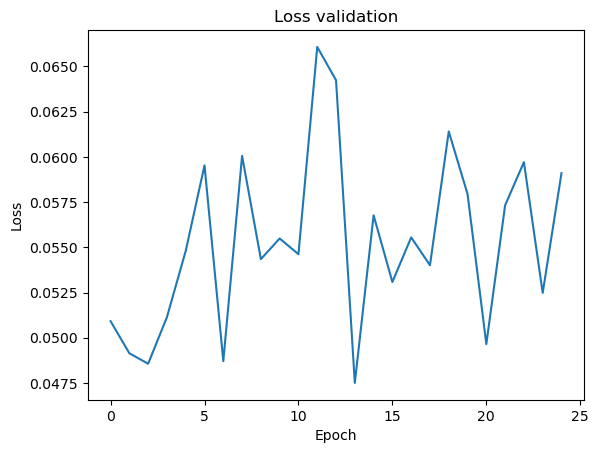

In [72]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-3
    image_size =28
    
config = Config()
main(config, train=train_bis_bis, path='mnist_model_train_bis_bis_15_3.pth')

In [73]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-4
    image_size =28
    
config = Config()
main(config, train=train_bis_bis, path='mnist_model_train_bis_bis_25_4.pth')

0it [00:00, ?it/s]

1488it [00:40, 36.97it/s]

In [ ]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-5
    image_size =28
    
config = Config()
main(config, train=train_bis_bis, path='mnist_model_train_bis_bis_25_5.pth')

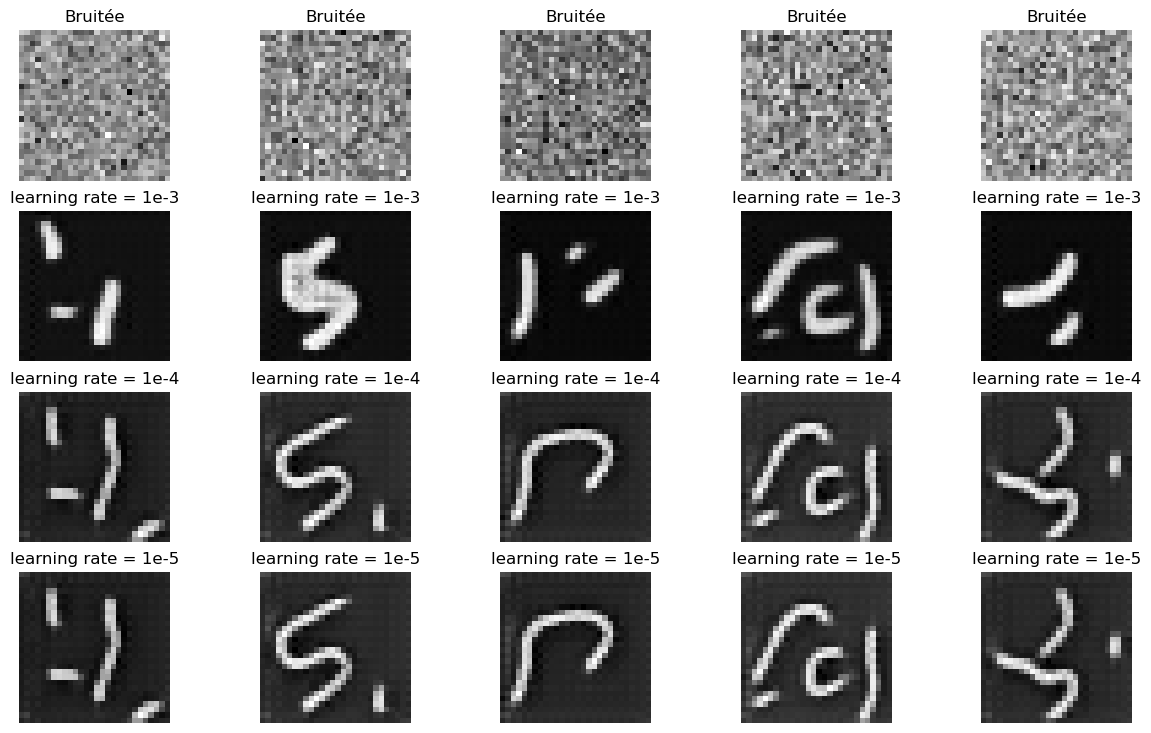

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

# we test the parametric model
model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_bis_bis_25_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_bis_bis_25_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_bis_bis_25_4.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images2 = model2(noisy_images)
denoised_images3 = model3(noisy_images)

for i in range (20):
    denoised_images1 = model1(denoised_images1)
    denoised_images2 = model2(denoised_images2)
    denoised_images3 = model3(denoised_images3)


fig, axs = plt.subplots(4, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('learning rate = 1e-5')
    axs[3, i].axis('off')

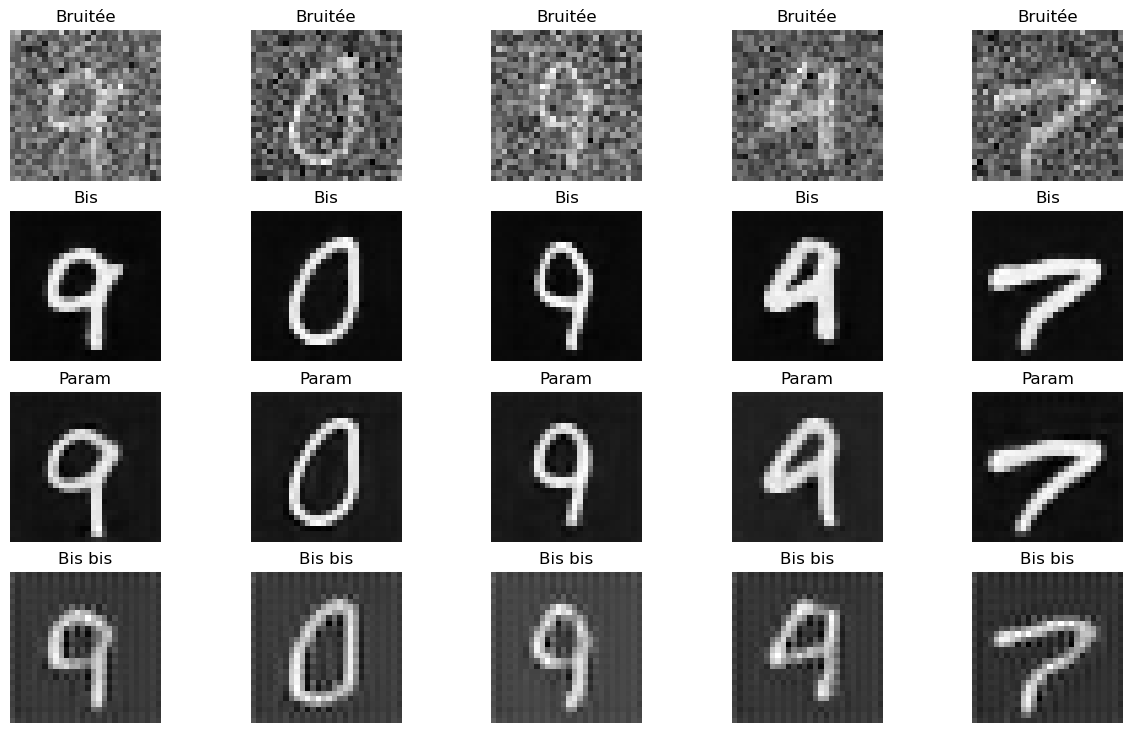

In [125]:
# comparaison des 3 models avec un learning rate de 1e-4

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

# we test the parametric model


model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_bis_25_5.pth'))

model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_param_0.1_25_5.pth'))


model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_bis_bis_25_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
noisy_images = images + 0.7* torch.randn_like(images)  # Ajout d'un bruit gaussien
#noisy_images = 0.5*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images2 = model2(noisy_images)
denoised_images3 = model3(noisy_images)

for i in range (10):
    denoised_images1 = model1(denoised_images1)
    denoised_images2 = model2(denoised_images2)
    denoised_images3 = model3(denoised_images3)
        
fig, axs = plt.subplots(4, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Bis')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Param')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('Bis bis')
    axs[3, i].axis('off')



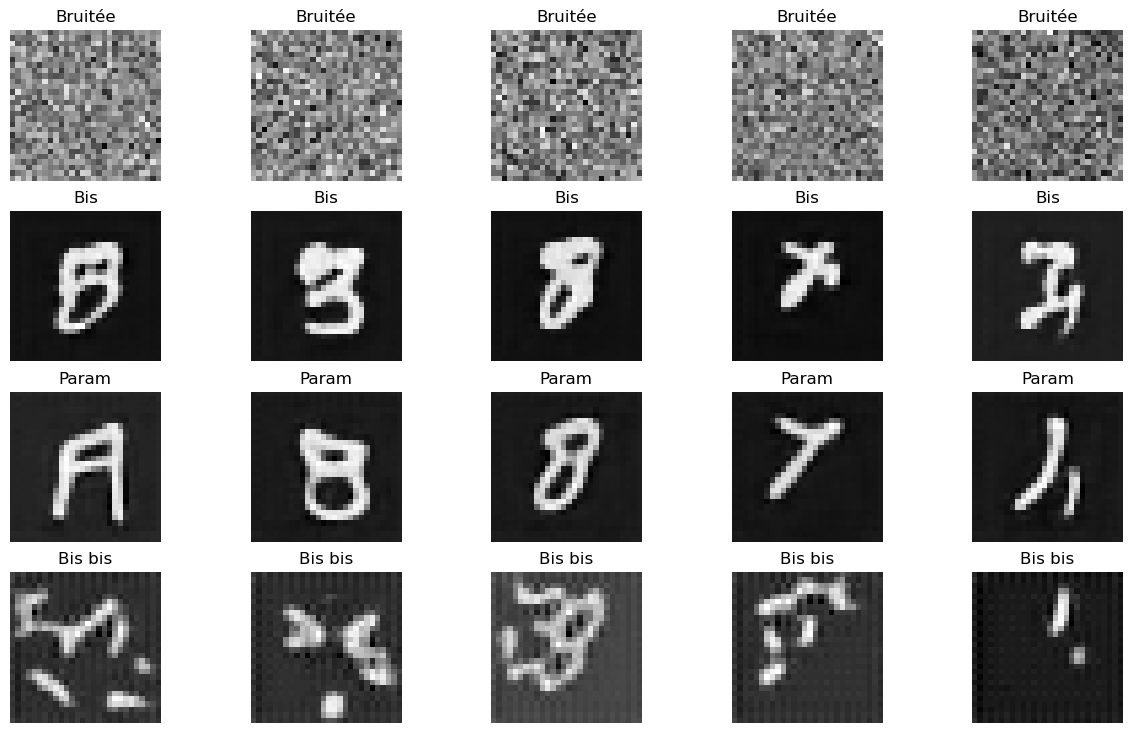

In [129]:
# comparaison des 3 models avec un learning rate de 1e-4

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

# we test the parametric model


model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_bis_25_5.pth'))

model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_param_0.1_25_5.pth'))


model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_bis_bis_25_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 0.7* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images2 = model2(noisy_images)
denoised_images3 = model3(noisy_images)

for i in range (10):
    denoised_images1 = model1(denoised_images1)
    denoised_images2 = model2(denoised_images2)
    denoised_images3 = model3(denoised_images3)
        
fig, axs = plt.subplots(4, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Bis')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Param')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('Bis bis')
    axs[3, i].axis('off')

